# Analysis

In this notebook, we analyze the different data we recorded during the experiments.
Namely, we study the following questions :
- Comparison in terms of train and validation losses, validation accuracies, execution time, appearance of the $\sqrt{d}$ factor
- Convergence to different or similar minima for the two optimizers

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import read_json

## Comparison of FO and ZO AdaMM w.r.t. the $\sqrt{d}$ bound
In this section, we investigate the difference between the FO and ZO methods in terms of train and validation losses, validation accuracies.

The plots on the execution times are only indicative. The experiments were run on different machines, sometimes multiple at the same time. All these parameters can greatly impact the actual exectution time. Therefore, it should not be taken as exact but rather as an indication of the performance.

In [2]:
def compare_FO_ZO_plot(fo_data_dict, zo_data_dict):
    """
    Plot the different performances quantities (losses, accuracies)
    for the two different optimizers
    :param fo_data_dict: data from the FO optimizer
    :param zo_data_dict: data from the ZO optimizer
    """
    fig, axs = plt.subplots( 1, 3)
    scale = fo_data_dict.get("config").get("scale")
    fo_values= list(fo_data_dict.items())[1][1]
    zo_values= list(zo_data_dict.items())[1][1]
    n_epochs = len(zo_values[0].get("train_accuracies"))
    n_experiments = len(zo_values)
    fig.suptitle(f"FO vs ZO AdaMM: scale {scale:.4f}", fontsize=16)
    zo_acc = np.zeros((n_experiments,n_epochs))
    zo_train_loss =np.zeros((n_experiments,n_epochs))
    zo_test_loss = np.zeros((n_experiments,n_epochs))
    fo_acc = np.zeros((n_experiments,n_epochs))
    fo_train_loss = np.zeros((n_experiments,n_epochs))
    fo_test_loss = np.zeros((n_experiments,n_epochs))
    for i in range(n_experiments):
        zo_acc[i,:] = zo_values[i].get("train_accuracies")
        zo_train_loss[i,:] = zo_values[i].get("train_losses")
        zo_test_loss[i,:] = zo_values[i].get("validation_losses")
        fo_acc[i,:] = fo_values[i].get("train_accuracies")
        fo_train_loss[i,:] = fo_values[i].get("train_losses")
        fo_test_loss[i,:] = fo_values[i].get("validation_losses")
    x = np.arange(0,n_epochs,1)

    axs[0].plot(zo_train_loss.mean(axis=0),label="ZO")
    axs[0].fill_between(x, zo_train_loss.mean(axis=0) - zo_train_loss.std(axis=0), zo_train_loss.mean(axis=0) + zo_train_loss.std(axis=0),  alpha =0.2)
    axs[0].plot(fo_train_loss.mean(axis=0),label="FO")
    axs[0].fill_between(x, fo_train_loss.mean(axis=0) - fo_train_loss.std(axis=0), fo_train_loss.mean(axis=0) + fo_train_loss.std(axis=0),  alpha =0.2)
    axs[0].set_title("Train Loss")
    axs[0].legend()
    axs[1].plot(zo_test_loss.mean(axis=0),label="ZO")
    axs[1].fill_between(x, zo_test_loss.mean(axis=0) - zo_test_loss.std(axis=0), zo_test_loss.mean(axis=0) + zo_test_loss.std(axis=0),  alpha =0.2)
    axs[1].plot(fo_test_loss.mean(axis=0),label="FO")
    axs[1].fill_between(x, fo_test_loss.mean(axis=0) - fo_test_loss.std(axis=0), fo_test_loss.mean(axis=0) + fo_test_loss.std(axis=0),  alpha =0.2)
    axs[1].set_title("Test Loss")
    axs[1].legend()
    axs[2].plot(zo_acc.mean(axis=0),label="ZO")
    axs[2].fill_between(x, zo_acc.mean(axis=0) - zo_acc.std(axis=0), zo_acc.mean(axis=0) + zo_acc.std(axis=0), alpha =0.2)
    axs[2].plot(fo_acc.mean(axis=0),label="FO")
    axs[2].fill_between(x, fo_acc.mean(axis=0) - fo_acc.std(axis=0), fo_acc.mean(axis=0) + fo_acc.std(axis=0), alpha =0.2)
    axs[2].set_title("Accuracy")
    axs[2].legend()
    fig = plt.gcf()
    fig.set_size_inches(24, 5)
    fig.text(0.5, 0.01, 'Epochs', ha='center')
    fig.text(0.04, 0.5, 'Score', va='center', rotation='vertical')

    fig, axs = plt.subplots( 1, 4)
    d = fo_values[0].get('nb_params')
    zo_time = np.zeros((n_experiments,n_epochs))
    fo_time = np.zeros((n_experiments,n_epochs))
    for i in range(n_experiments):
        zo_time[i,:] = zo_values[i].get("epoch_time")
        fo_time[i,:] = fo_values[i].get("epoch_time")
    x = np.arange(0,n_epochs,1)
    #ratio_acc = fo_acc/zo_acc
    eps = 0.0
    ratio_train_loss = (zo_train_loss/((fo_train_loss + eps)*math.sqrt(d)))
    ratio_test_loss = (zo_test_loss/((fo_test_loss + eps)*math.sqrt(d)))
    ratio_acc = (zo_acc/((fo_acc + eps)*math.sqrt(d)))
    #axs[0].plot(ratio_acc.mean(axis=0),label="Acc. ratio")
    #axs[0].fill_between(x, ratio_acc.mean(axis=0) - ratio_acc.std(axis=0), ratio_acc.mean(axis=0) + ratio_acc.std(axis=0), alpha =0.2)
    axs[0].plot(ratio_train_loss.mean(axis=0),'g',label="Train k")
    axs[0].fill_between(x, ratio_train_loss.mean(axis=0) - ratio_train_loss.std(axis=0), ratio_train_loss.mean(axis=0) + ratio_train_loss.std(axis=0),color='g', alpha =0.2)
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("K")
    axs[0].set_title(f"Train k = ZO_tr_loss/(FO_tr_loss*sqrt(d={d/1000:.2f}k)")
    #axs[0].set_yscale('log')
    axs[0].legend()
    axs[1].plot(ratio_test_loss.mean(axis=0),'r',label="Test k")
    axs[1].fill_between(x, ratio_test_loss.mean(axis=0) - ratio_test_loss.std(axis=0), ratio_test_loss.mean(axis=0) + ratio_test_loss.std(axis=0),color='r', alpha =0.2)
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("K")
    axs[1].set_title(f"Test k = ZO_test_loss/(FO_test_loss*sqrt(d={d/1000:.2f}k)")
    axs[1].legend()
    axs[2].plot(ratio_acc.mean(axis=0),'k',label="Acc k")
    axs[2].fill_between(x, ratio_acc.mean(axis=0) - ratio_acc.std(axis=0), ratio_acc.mean(axis=0) + ratio_acc.std(axis=0),color='k', alpha =0.2)
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("K")
    axs[2].set_title(f"Acc k = ZO_acc/(FO_acc*sqrt(d={d/1000:.2f}k)")
    axs[2].legend()
    fo_time = fo_time.flatten()
    zo_time = zo_time.flatten()
    fo_x_axis = np.arange(fo_time.min(), fo_time.max(), 0.01)
    zo_x_axis = np.arange(zo_time.min(), zo_time.max(), 0.01)
    axs[3].plot(zo_x_axis, stats.norm.pdf(zo_x_axis, zo_time.mean(), zo_time.std()), label="ZO")
    axs[3].plot(fo_x_axis,stats.norm.pdf(fo_x_axis, fo_time.mean(), fo_time.std()),label="FO")
    axs[3].set_title("Epoch computation time")
    axs[3].set_xlabel("Time (seconds)")
    axs[3].set_ylabel("Frequency")
    axs[3].legend()

    fig = plt.gcf()
    fig.set_size_inches(24, 5)
    plt.show()

### K value explanation
Theoretically, the convergence rate of zeroth-order (ZO) AdaMM for both convex and nonconvex optimization is roughly a factor of $O(\sqrt{d})$
worse than that of the first-order (FO) AdaMM algorithm, where d is problem size ( number of the model's parameters ). This means that:

$Loss_{ZO} = Loss_{FO}\cdot\sqrt{d}\cdot k $

with  $k\in\mathbb{R}$
Hence:
    $k = \frac{Loss_{ZO}}{Loss_{FO}\cdot\sqrt{d}} $

Same goes for the measured $Accuracy_{ZO}$ and $Accuracy_{FO}$.


We now plot these values as well as the performances (losses, accuracies) for the different scales (model sizes) considered.

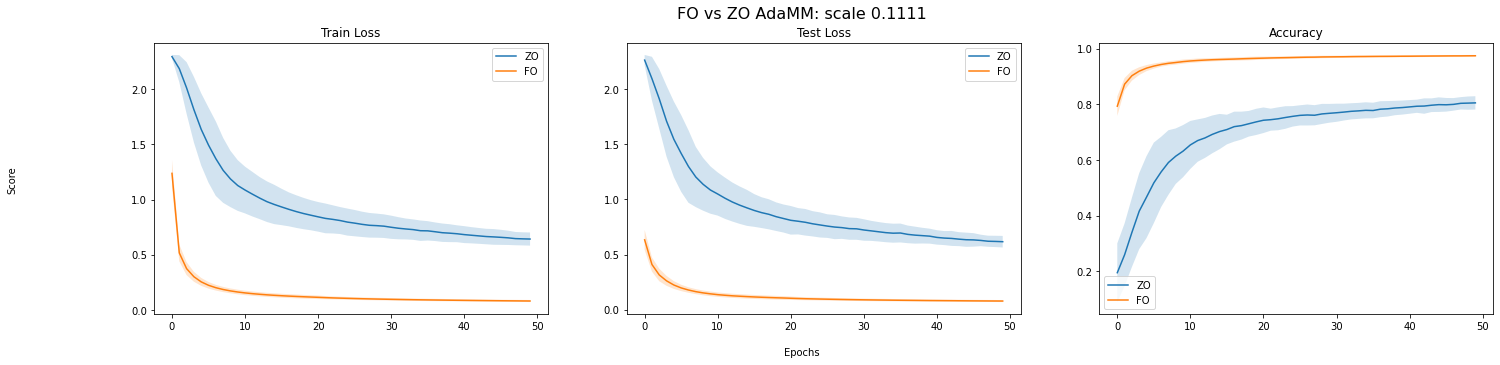

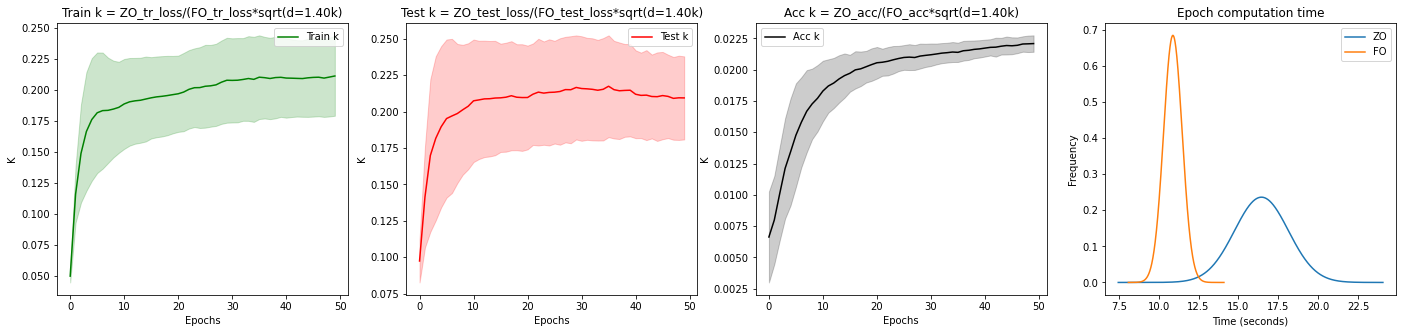

In [3]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_0.111111.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_0.111111.json'))

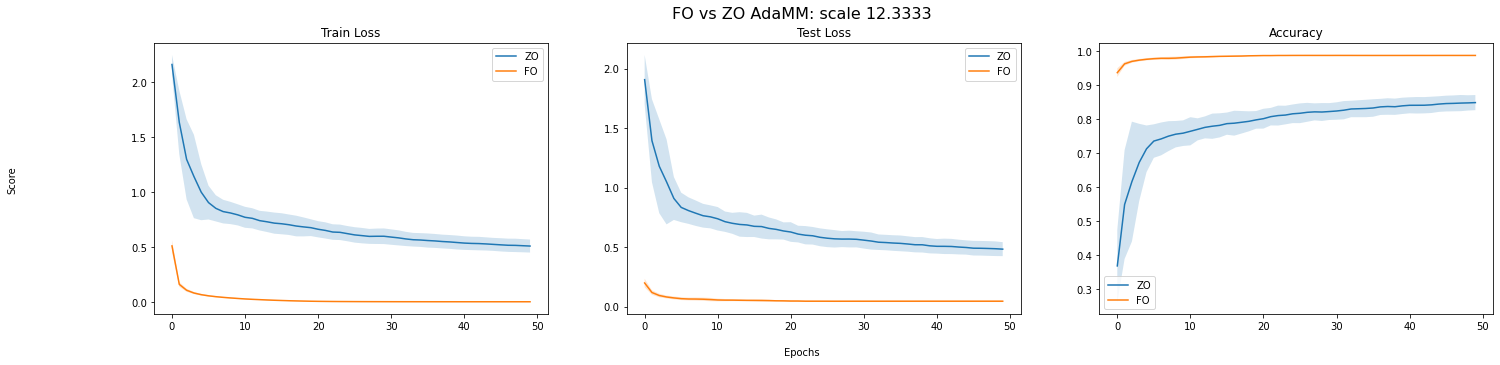

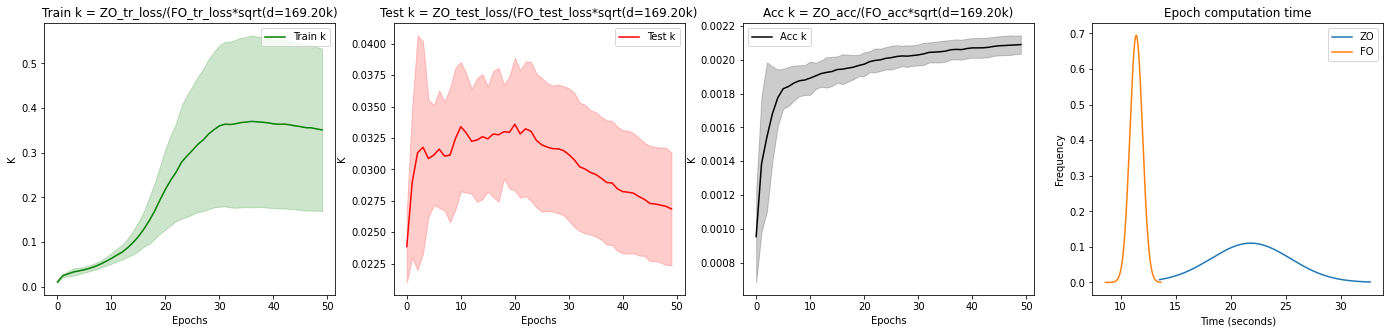

In [4]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_12.333333.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_12.330000.json'))

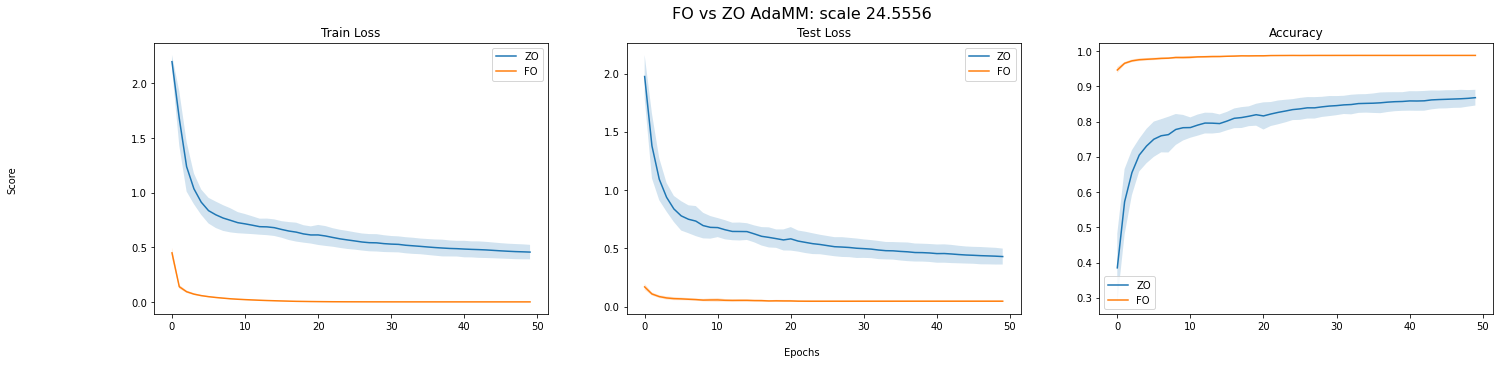

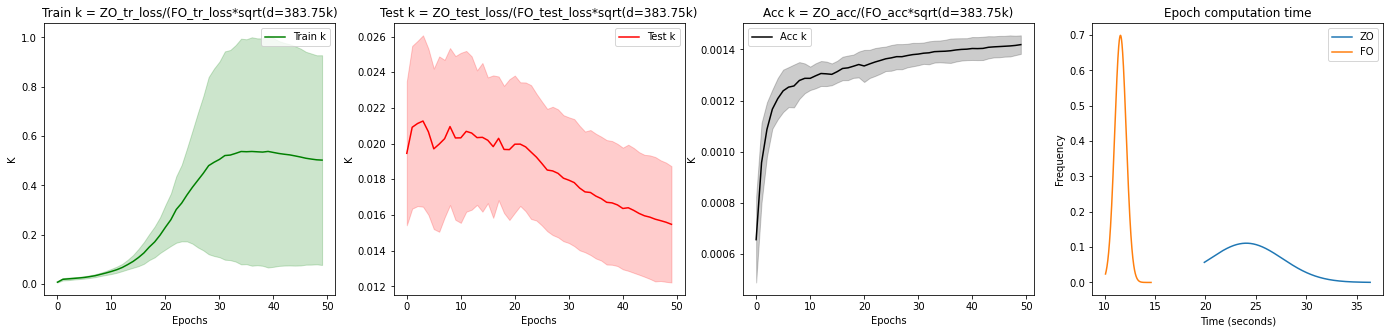

In [5]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_24.555555.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_24.549999.json'))

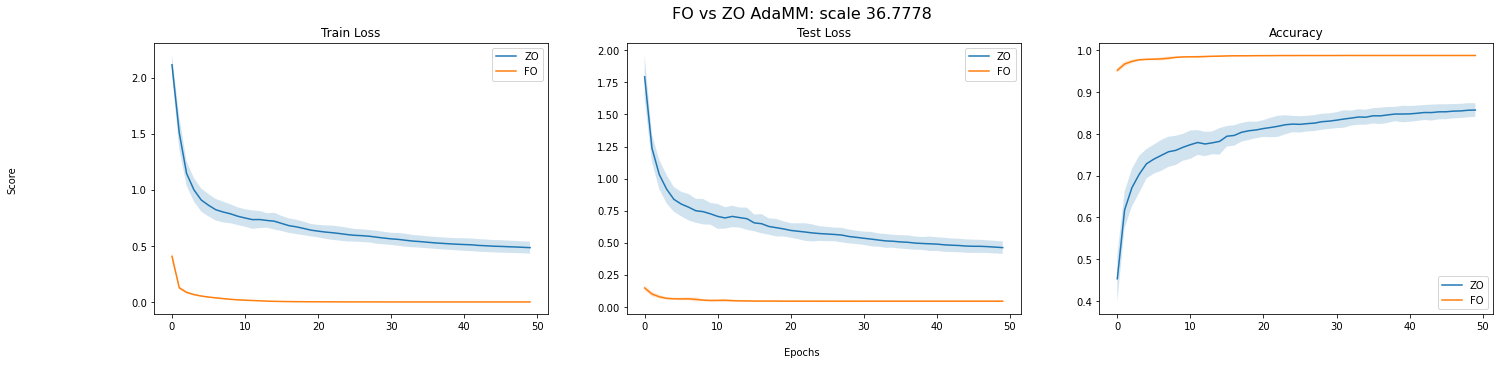

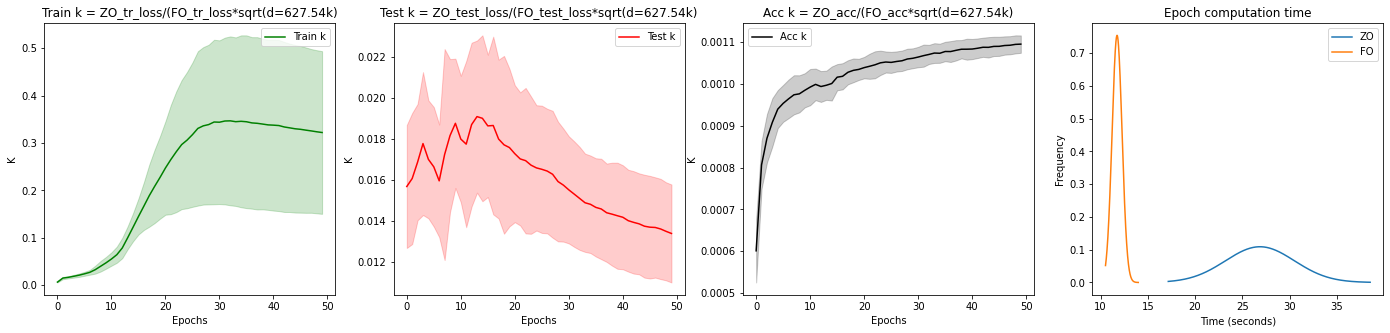

In [6]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_36.777779.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_36.770000.json'))

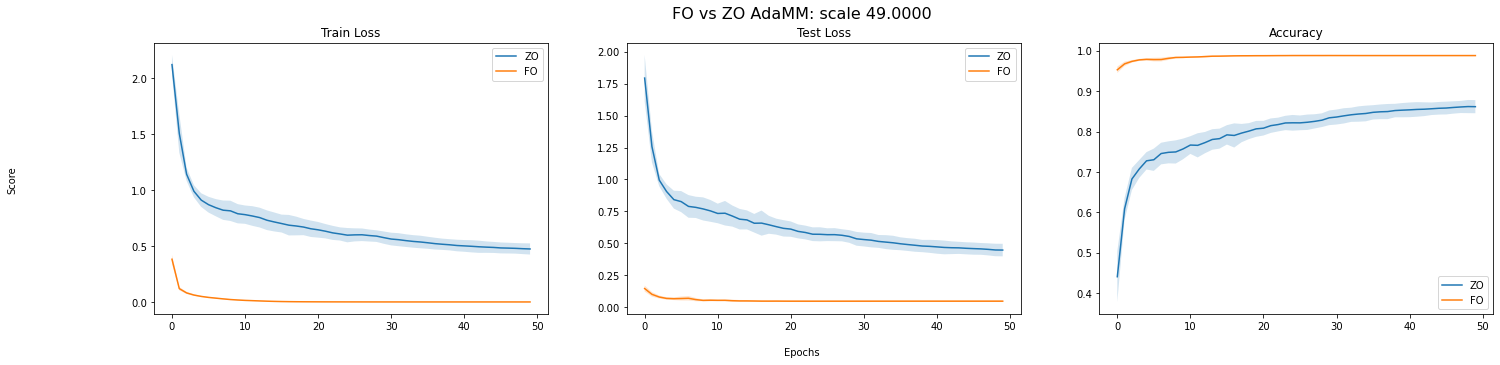

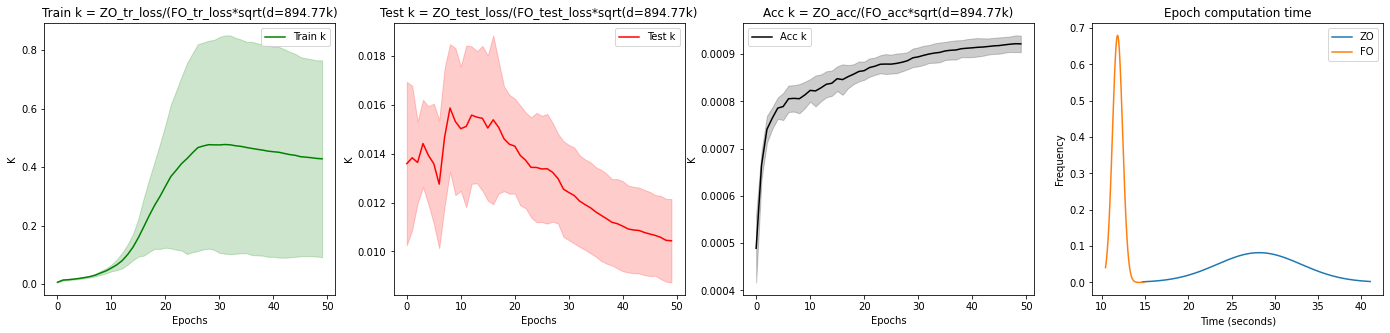

In [7]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_49.000000.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_49.000000.json'))

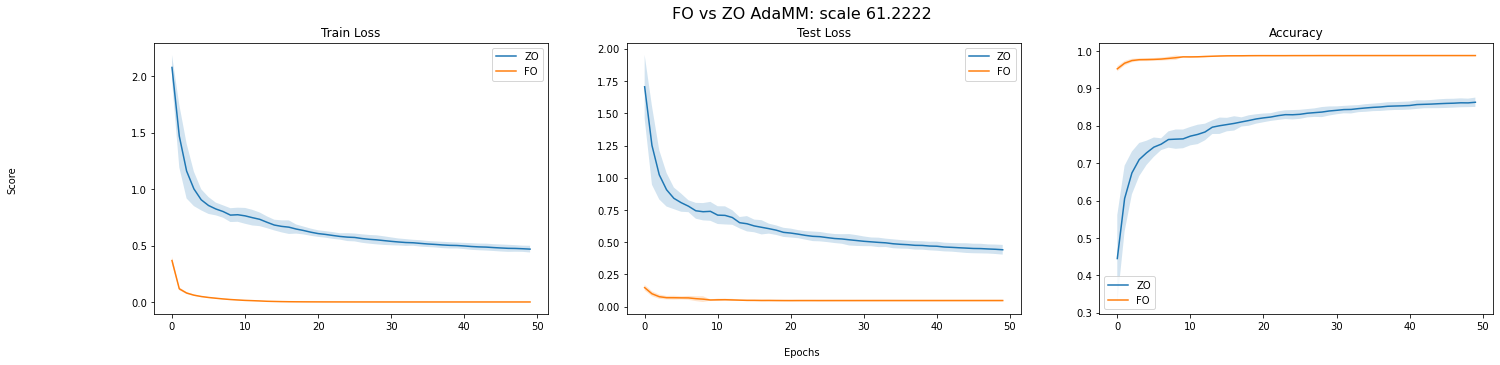

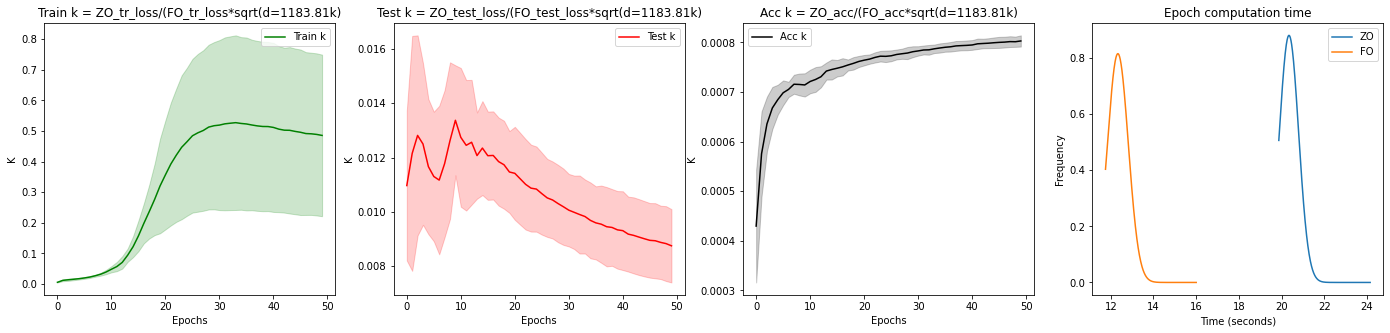

In [8]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_61.222221.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_61.222221.json'))

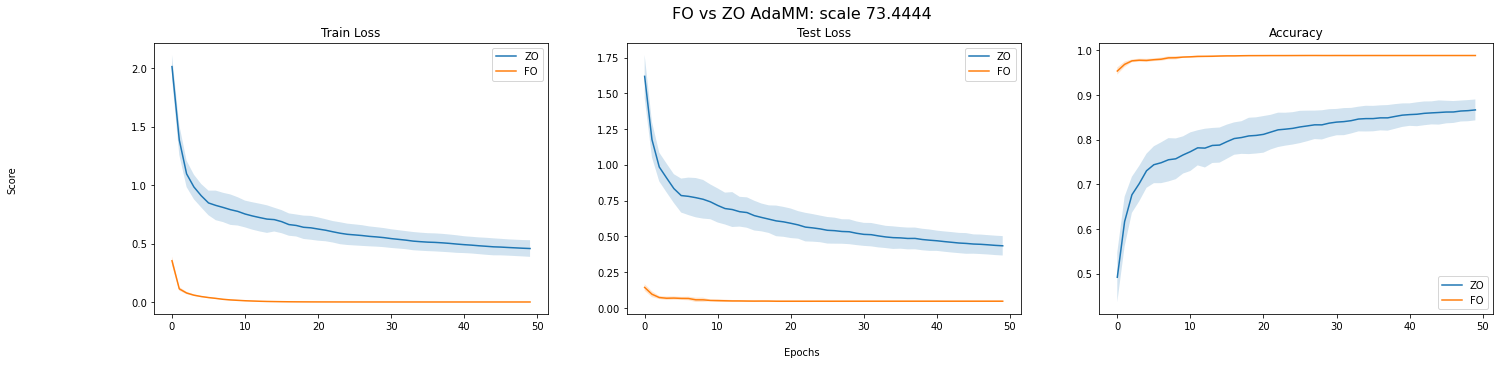

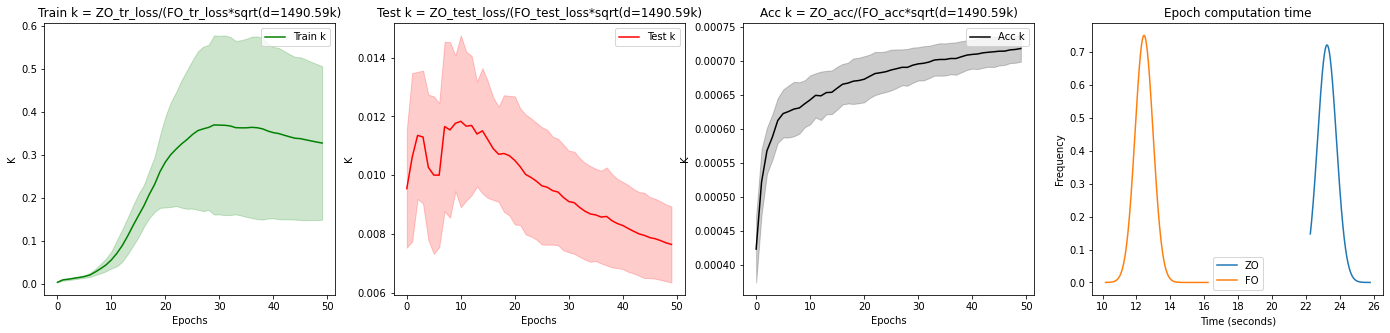

In [9]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_73.444443.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_73.444443.json'))

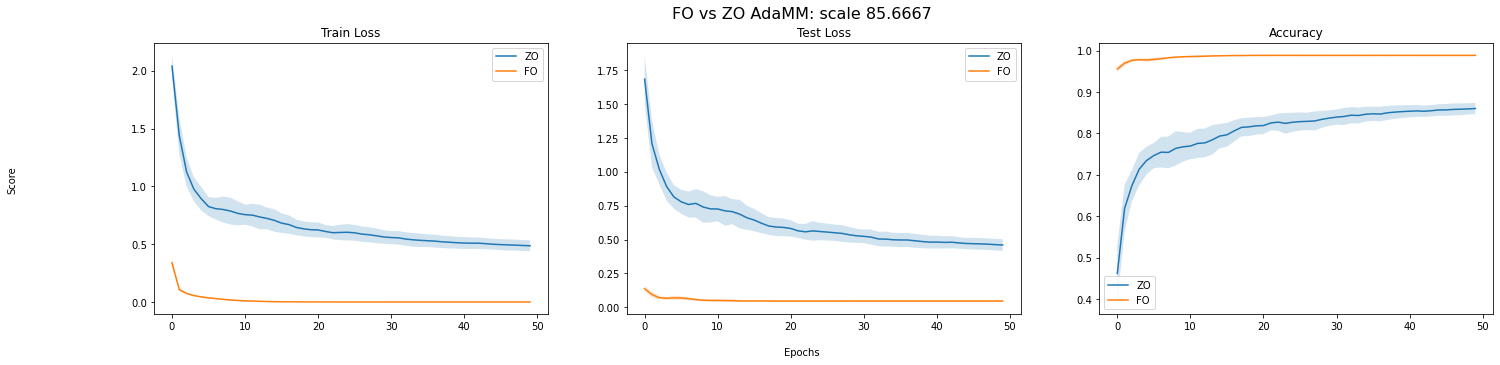

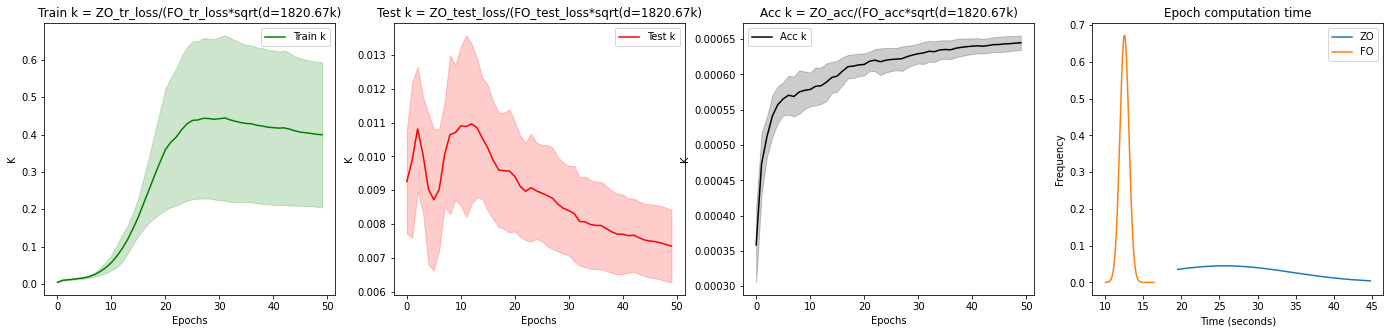

In [10]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_85.666664.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_85.666664.json'))

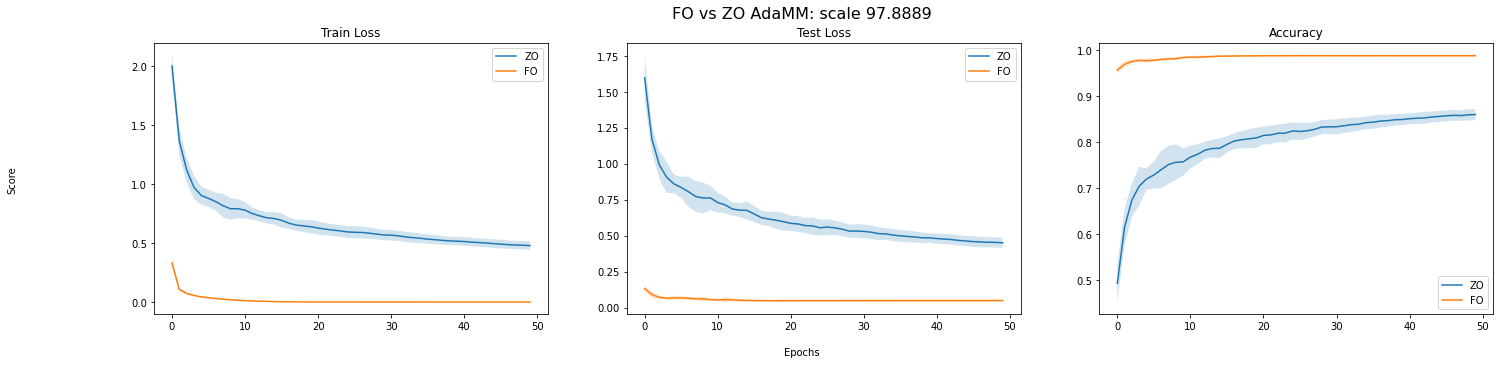

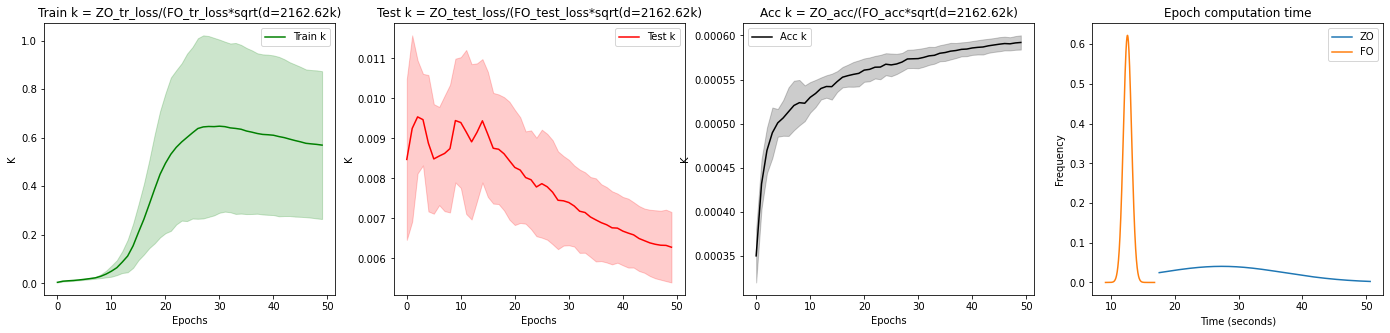

In [11]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_97.888885.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_97.888885.json'))

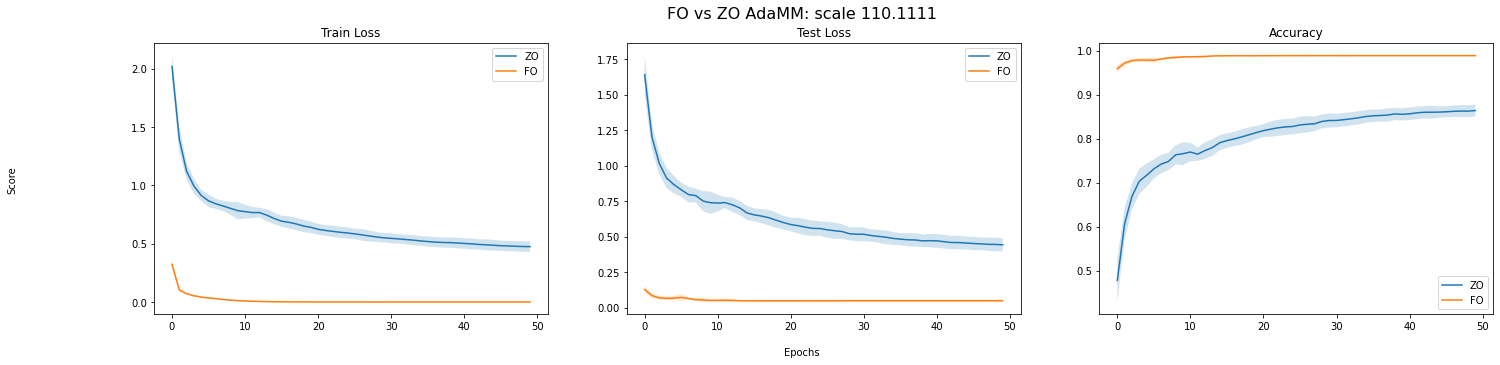

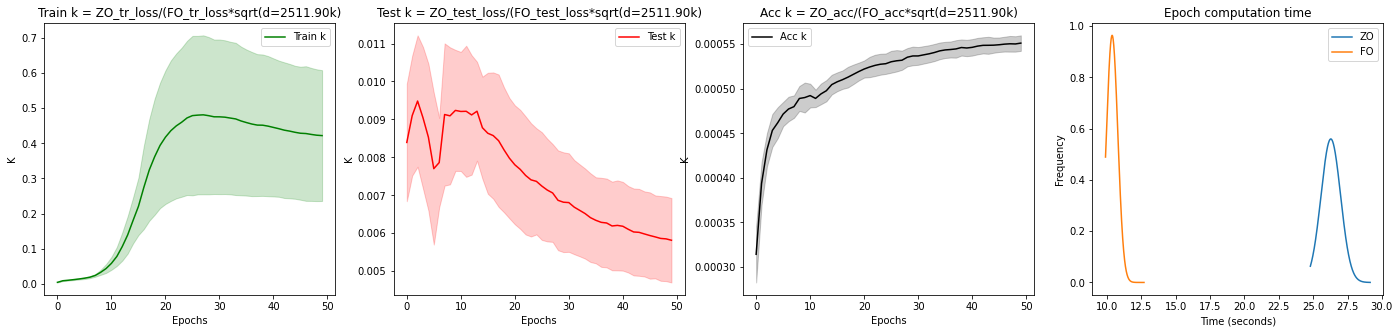

In [12]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_110.111107.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_110.111107.json'))

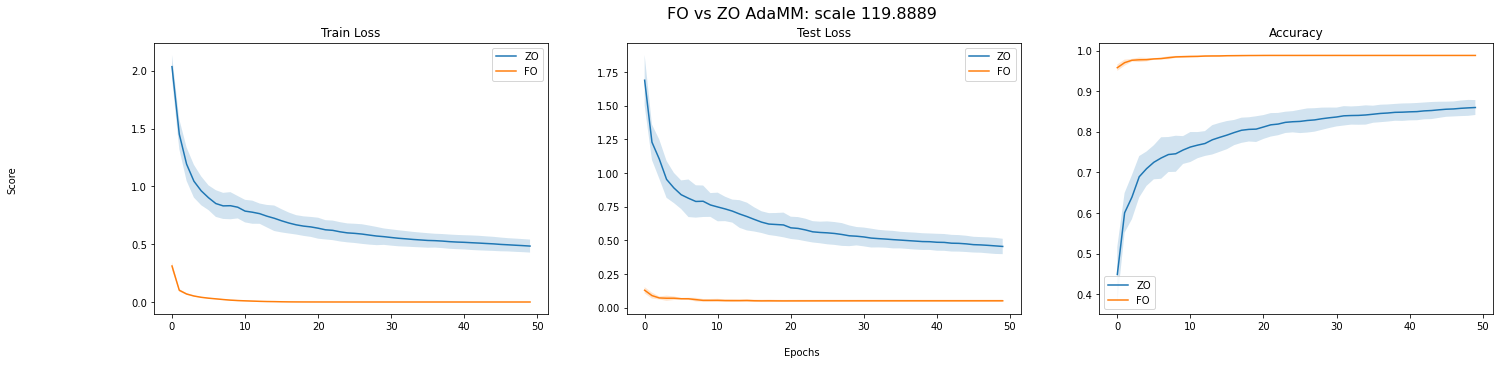

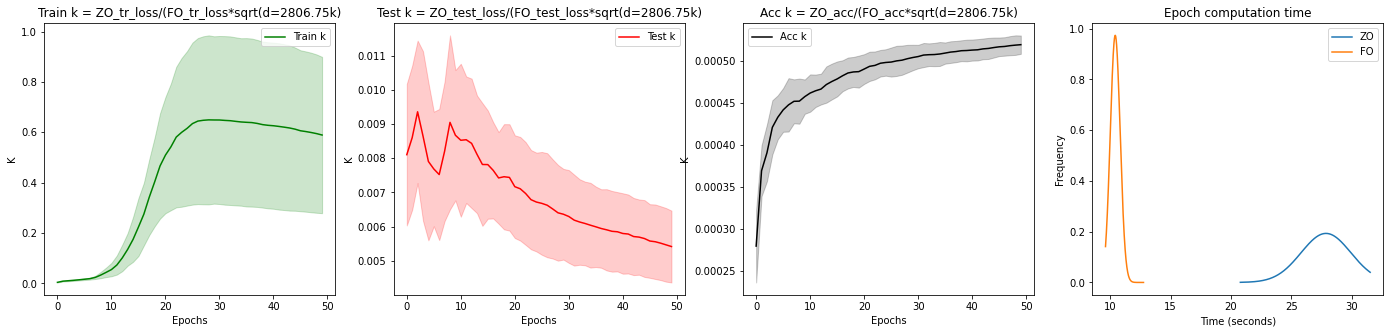

In [13]:
compare_FO_ZO_plot(fo_data_dict=read_json('results/result_AdaMM_119.888885.json'),zo_data_dict=read_json('results/result_ZO-AdaMM_119.888885.json'))

### Summary for K values

In this section, we consider the different quantities studied above but in a more grouped manner across the scales.

In [14]:
# Grouping all the data together

fo_files=['results/result_AdaMM_0.111111.json','results/result_AdaMM_12.333333.json','results/result_AdaMM_24.555555.json','results/result_AdaMM_36.777779.json','results/result_AdaMM_49.000000.json','results/result_AdaMM_73.444443.json','results/result_AdaMM_85.666664.json','results/result_AdaMM_97.888885.json','results/result_AdaMM_110.111107.json','results/result_AdaMM_119.888885.json']
zo_files=['results/result_ZO-AdaMM_0.111111.json','results/result_ZO-AdaMM_12.330000.json','results/result_ZO-AdaMM_24.549999.json','results/result_ZO-AdaMM_36.770000.json','results/result_ZO-AdaMM_49.000000.json','results/result_ZO-AdaMM_73.444443.json','results/result_ZO-AdaMM_85.666664.json','results/result_ZO-AdaMM_97.888885.json','results/result_ZO-AdaMM_110.111107.json','results/result_ZO-AdaMM_119.888885.json']
scales = []
n_epochs = 0
n_experiments = 0
d= []

fo_accuracies = []
fo_train_losses = []
fo_test_losses = []
fo_times = []

zo_accuracies = []
zo_train_losses = []
zo_test_losses = []
zo_times = []

ratio_train_loss = []
ratio_test_loss = []
ratio_acc = []

for i in range(len(fo_files)):
    fo_data_dict = read_json(fo_files[i])
    zo_data_dict = read_json(zo_files[i])
    scales.append(fo_data_dict.get("config").get("scale"))
    fo_values= list(fo_data_dict.items())[1][1]
    zo_values= list(zo_data_dict.items())[1][1]
    n_epochs = len(zo_values[0].get("train_accuracies"))
    n_experiments = len(zo_values)
    zo_acc = np.zeros((n_experiments,n_epochs))
    zo_train_loss =np.zeros((n_experiments,n_epochs))
    zo_test_loss = np.zeros((n_experiments,n_epochs))
    fo_acc = np.zeros((n_experiments,n_epochs))
    fo_train_loss = np.zeros((n_experiments,n_epochs))
    fo_test_loss = np.zeros((n_experiments,n_epochs))
    zo_time = np.zeros((n_experiments,n_epochs))
    fo_time = np.zeros((n_experiments,n_epochs))
    for i in range(n_experiments):
        zo_acc[i,:] = zo_values[i].get("train_accuracies")
        zo_train_loss[i,:] = zo_values[i].get("train_losses")
        zo_test_loss[i,:] = zo_values[i].get("validation_losses")
        fo_acc[i,:] = fo_values[i].get("train_accuracies")
        fo_train_loss[i,:] = fo_values[i].get("train_losses")
        fo_test_loss[i,:] = fo_values[i].get("validation_losses")
        zo_time[i,:] = zo_values[i].get("epoch_time")
        fo_time[i,:] = fo_values[i].get("epoch_time")
    d.append(fo_values[0].get('nb_params'))
    ratio_train_loss.append((zo_train_loss/((fo_train_loss)*math.sqrt(d[-1]))))
    ratio_test_loss.append((zo_test_loss/((fo_test_loss)*math.sqrt(d[-1]))))
    ratio_acc.append((zo_acc/((fo_acc)*math.sqrt(d[-1]))))

    fo_accuracies.append(fo_acc)
    fo_train_losses.append(fo_train_loss)
    fo_test_losses.append(fo_test_loss)
    fo_times.append(fo_time)
    zo_accuracies.append(zo_acc)
    zo_train_losses.append(zo_train_loss)
    zo_test_losses.append(zo_test_loss)
    zo_times.append(zo_time)

In [15]:
def plot_ratio_zo_fo_through_scales( fo_data,zo_data, d, title, xtitle, ytitle, n_epochs,yscale, plot_std = False, inverse_ratio = False, savename = None):
    fig, axs = plt.subplots( 1, 1)
    fig.suptitle(title, fontsize=13)
    x = np.arange(0,n_epochs,1)
    for i,d_value in enumerate(d):
        data = np.divide(zo_data[i],fo_data[i])
        if inverse_ratio:
            data = np.divide(fo_data[i],zo_data[i])
        mean = data.mean(axis=0)
        axs.plot(mean,label=f"d={d_value:.0f}")
        if plot_std:
            std = data.std(axis=0)
            axs.fill_between(x, mean - std, mean + std,  alpha =0.2)
        axs.legend()
    axs.set_yscale(yscale)
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    fig.text(0.5, 0.01, xtitle, ha='center')
    fig.text(0.00, 0.5, ytitle, va='center', rotation='vertical')
    if savename is not None:
        plt.savefig(savename)
    plt.show()

In the figure below, we plot the ratio of train loss ZO/FO for all the scales during training.

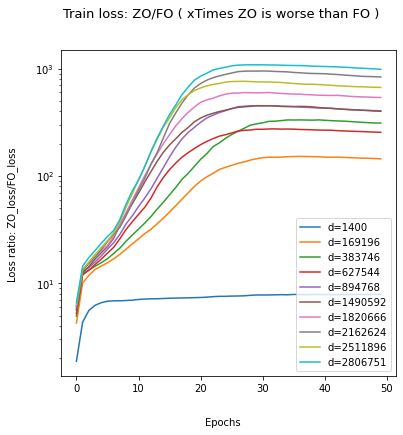

In [16]:
plot_ratio_zo_fo_through_scales(fo_train_losses,zo_train_losses, d,"Train loss: ZO/FO ( xTimes ZO is worse than FO ) ", "Epochs", "Loss ratio: ZO_loss/FO_loss", n_epochs, yscale = 'log', savename="plots/TrainLoss")

In the figure below, we plot the ratio of test loss ZO/FO for all the scales during training.

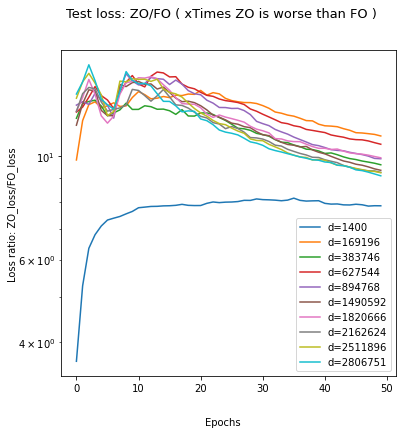

In [17]:
plot_ratio_zo_fo_through_scales(fo_test_losses,zo_test_losses, d,"Test loss: ZO/FO ( xTimes ZO is worse than FO ) ", "Epochs", "Loss ratio: ZO_loss/FO_loss", n_epochs, yscale = 'log')

In [18]:
for i in range(len(fo_accuracies)):
    fo_accuracies[i]= fo_accuracies[i][:,15:]
    zo_accuracies[i]= zo_accuracies[i][:,15:]

In the figure below, we plot the ratio of accuracy FO/ZO for all the scales during training.

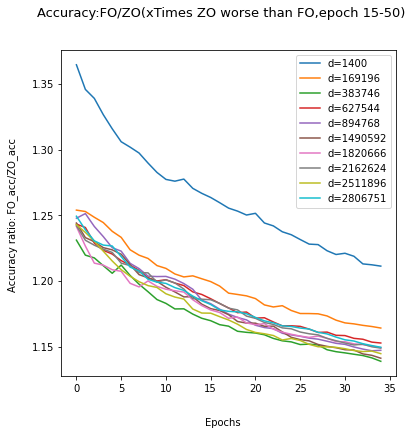

In [19]:
plot_ratio_zo_fo_through_scales(fo_accuracies,zo_accuracies, d,"Accuracy:FO/ZO(xTimes ZO worse than FO,epoch 15-50) ", "Epochs", "Accuracy ratio: FO_acc/ZO_acc", 35, inverse_ratio = True, yscale = 'linear' , savename="plots/Acc")

In [20]:
def plot_k_values_through_scales( k_values, d, title, xtitle, ytitle, n_epochs,yscale, plot_std = False, savename = None):
    fig, axs = plt.subplots( 1, 1)
    fig.suptitle(title, fontsize=16)
    x = np.arange(0,n_epochs,1)
    for i,d_value in enumerate(d):
        mean = k_values[i].mean(axis=0)
        axs.plot(mean,label=f"d={d_value:.0f}")
        if plot_std:
            std = k_values[i].std(axis=0)
            axs.fill_between(x, mean - std, mean + std,  alpha =0.2)
        axs.legend()
    axs.set_yscale(yscale)
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    fig.text(0.5, 0.01, xtitle, ha='center')
    fig.text(0.04, 0.5, ytitle, va='center', rotation='vertical')
    if savename is not None:
        plt.savefig(savename)
    plt.show()

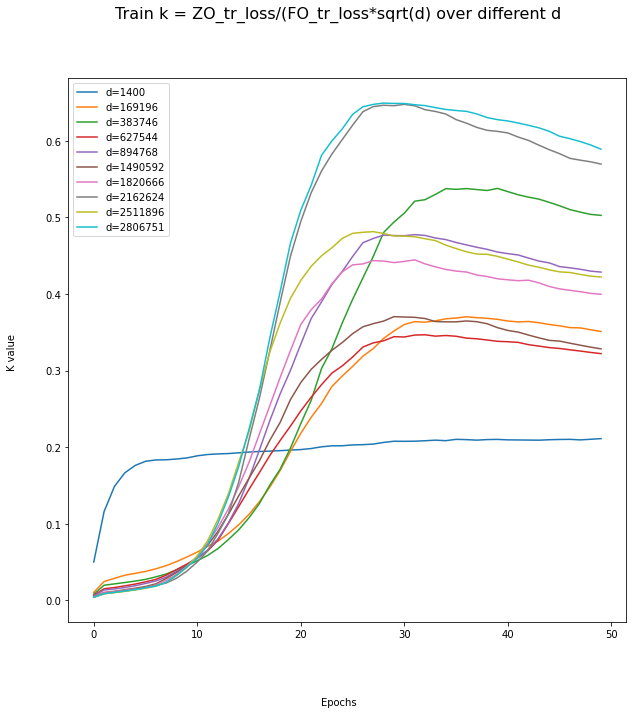

In [21]:
plot_k_values_through_scales(ratio_train_loss, d,"Train k = ZO_tr_loss/(FO_tr_loss*sqrt(d) over different d", "Epochs", "K value", n_epochs, yscale = 'linear', plot_std=False , savename="plots/TrainK")

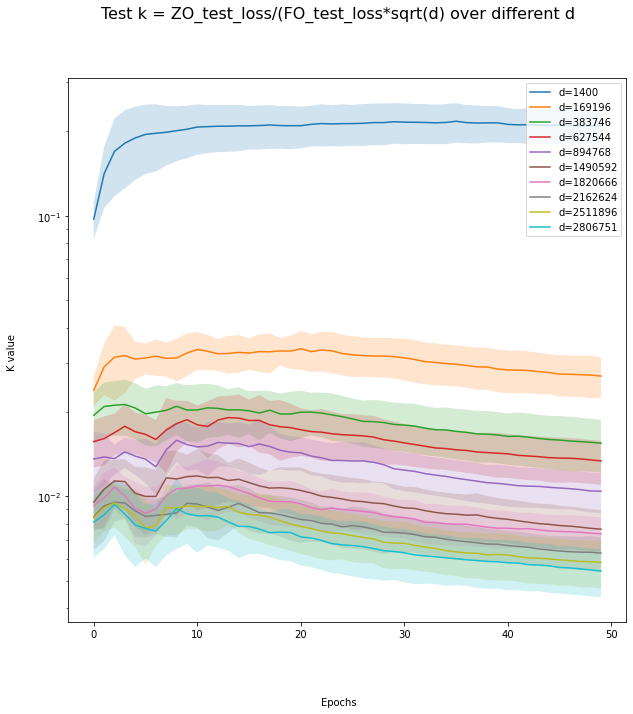

In [22]:
plot_k_values_through_scales(ratio_test_loss, d,"Test k = ZO_test_loss/(FO_test_loss*sqrt(d) over different d", "Epochs", "K value", n_epochs, yscale = 'log', plot_std=True )

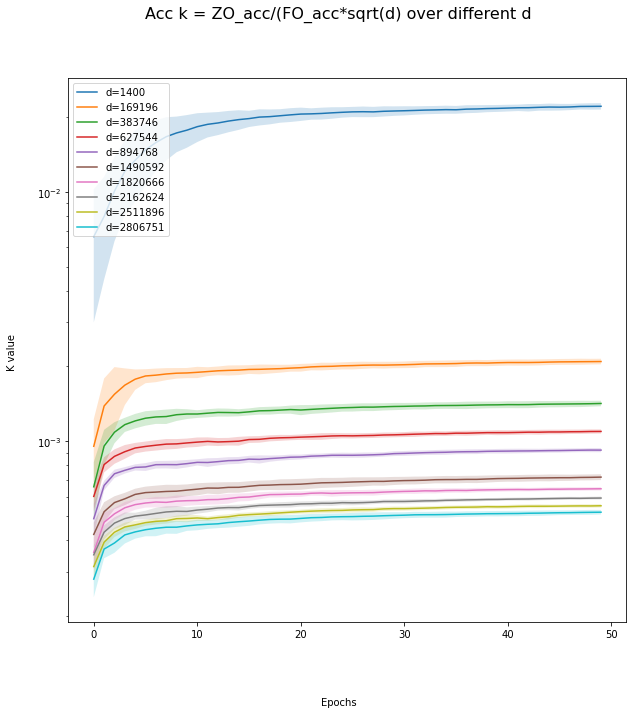

In [23]:
plot_k_values_through_scales(ratio_acc, d,"Acc k = ZO_acc/(FO_acc*sqrt(d) over different d", "Epochs", "K value", n_epochs, yscale = 'log', plot_std=True )

In [24]:
def plot_time_through_scales( fo_time, zo_time , d, title, xtitle, ytitle,yscale, plot_std = False):
    fig, axs = plt.subplots( 1, 1)
    fig.suptitle(title, fontsize=16)
    zo_means = np.zeros((len(d)))
    fo_means = np.zeros((len(d)))
    zo_std = np.zeros((len(d)))
    fo_std = np.zeros((len(d)))
    d_vales = np.array(d)
    for i in range(len(zo_time)):
        zo_means[i] = zo_time[i].flatten().mean()
        fo_means[i] = fo_time[i].flatten().mean()
        zo_std[i] = zo_time[i].flatten().std()
        fo_std[i] = fo_time[i].flatten().std()

    axs.plot(d_vales,zo_means,label="ZO")
    if plot_std:
        axs.fill_between(d_vales, zo_means - zo_std, zo_means + zo_std,  alpha =0.2)
    axs.plot(d_vales,fo_means,label="FO")
    if plot_std:
        axs.fill_between(d_vales, fo_means - fo_std, fo_means + fo_std,  alpha =0.2)
    axs.legend()
    axs.set_yscale(yscale)
    axs.set_xscale("log")
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    fig.text(0.5, 0.01, xtitle, ha='center')
    fig.text(0.04, 0.5, ytitle, va='center', rotation='vertical')
    plt.show()

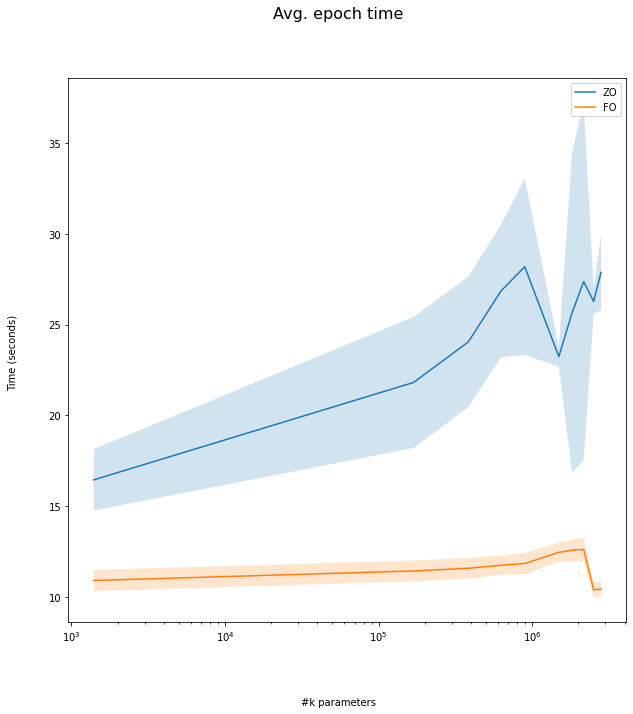

In [25]:
plot_time_through_scales( fo_times, zo_times , d, "Avg. epoch time", "#k parameters", "Time (seconds)",yscale='linear', plot_std = True)

## Comparison of weights and minima
In this section, we investigate whether the two optimizer tend to make the models converge to similar minima, i.e. similar weights.
For this analysis, we consider only the smallest model with 1'400 parameters.

We look at the following :
- Cosine similarities between the weights obtained with the FO and ZO AdaMM
- Projection of the weights using the t-SNE method

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def compare_weights(fo_data_list, zo_data_list, ax, title='', distance=True):
    """
    Compute and plot the distance between the weights vector obtained
    during the training with the FO and ZO-AdaMM
    :param fo_data_list: weights sequences of AdaMM
    :param zo_data_list: weights sequences of ZO-AdaMM
    """
    comparisons = np.zeros((len(fo_data_list), fo_data_list[0].shape[0]))

    for i, (fo, zo) in enumerate(zip(fo_data_list, zo_data_list)):
        if distance:
            # Compute L2-distance between the parameters vector each 5 epochs
            # for each experiment
            comparisons[i, :] = np.sqrt(np.sum(((fo - zo) ** 2), axis=1))
        else:
            norm_zo = np.sqrt(np.sum(zo**2, axis=1))
            norm_fo = np.sqrt(np.sum(fo**2, axis=1))
            comparisons[i, :] = np.diag(fo @ zo.T) / (norm_zo * norm_fo)

    mean_distances = np.mean(comparisons, axis=0)
    std_distances = np.std(comparisons, axis=0)

    x = np.arange(mean_distances.shape[0])
    ax.plot(x, mean_distances, marker='o')
    ax.fill_between(x, mean_distances - std_distances, mean_distances + std_distances, alpha=0.2)

    ax.set_title(f'Layer : {title}')


def load_weights_sequence(path, nb):
    """
    Loads all the files beginning with 'path'
    :param path: root name of the files to load
    :param nb: nb of files to load
    :return: list of numpy array
    """
    results = []

    for i in range(nb):
        results.append(np.load(f'{path}_{i}.npy'))

    return results


def load_weights_sequence_all_layers(path_zo, path_fo, nb, conv_layers):
    """
    Load the weights sequence of the given layers for both
    FO and ZO optimizers.
    :param path_zo: path for the zo files
    :param path_fo: path for the fo files
    :param nb: number of experiments done
    :param conv_layers: whether to load the conv layers or fc layers
    :return: dict containing the data
    """
    conv_layers_names = ['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias']
    fc_layers_names = ['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias']
    layers_names = conv_layers_names if conv_layers else fc_layers_names

    data = dict()
    for l in layers_names:
        data[l] = dict()
        data[l]['zo'] = load_weights_sequence(f'{path_zo}_{l}', nb)
        data[l]['fo'] = load_weights_sequence(f'{path_fo}_{l}', nb)

    return data


def compare_weights_all_layers(path_zo, path_fo, nb=10, distance=True, save=True):
    """
    Plot the weights comparison graphs for all the layers of the model.
    :param path_zo: path for the zo files
    :param path_fo: path for the fo files
    :param nb: number of experiments done
    :param distance: whether to use the L2 distance or cosine similarity
    """
    conv_data = load_weights_sequence_all_layers(path_zo, path_fo, nb, conv_layers=True)
    fc_data = load_weights_sequence_all_layers(path_zo, path_fo, nb, conv_layers=False)

    # Plot the convolutional layers
    fig, axs = plt.subplots(2, 2)

    for i, (l, d) in enumerate(conv_data.items()):
        compare_weights(d['fo'], d['zo'], axs[i // 2, i % 2], title=l, distance=distance)

    fig = plt.gcf()
    fig.set_size_inches(10, 6.6)
    fig.tight_layout()
    plt.setp(axs[-1, :], xlabel='Epochs')
    plt.setp(axs[:, 0], ylabel='Distance' if distance else 'Similarity')
    if save:
        plt.savefig(f'plots/weights_conv_{"distance" if distance else "cosine_similarities"}.png')

    fig, axs = plt.subplots(3, 2)

    for i, (l, d) in enumerate(fc_data.items()):
        compare_weights(d['fo'], d['zo'], axs[i // 2, i % 2], title=l, distance=distance)

    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    fig.tight_layout()
    plt.setp(axs[-1, :], xlabel='Epochs')
    plt.setp(axs[:, 0], ylabel='Distance' if distance else 'Similarity')

    if save:
        plt.savefig(f'plots/weights_fc_{"distance" if distance else "cosine_similarities"}.png')
    plt.show()


def project_weights(zo_data_list, fo_data_list, ax, title='', use_pca=False):
    """
    Project down and plot the weights (use all the experiments to compute the projection
    but plot only the one of the first experiment).
    :param fo_data_list: weights sequences of AdaMM
    :param zo_data_list: weights sequences of ZO-AdaMM
    :param use_pca: boolean or 'auto'. Whether to use PCA do first reduce the
    number of dimensions. 'auto' automatically use PCA is the dimensions is larger than 100
    """
    nb_zo = zo_data_list[0].shape[0]
    X = np.vstack(zo_data_list + fo_data_list)

    if isinstance(use_pca, bool) and use_pca or isinstance(use_pca, str) and use_pca == 'auto' and X.shape[1] >= 100:
        X = PCA(n_components=50, random_state=42).fit_transform(X)

    X_emb = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42).fit_transform(X)

    X_emb_zo = X_emb[:nb_zo * len(zo_data_list), :]
    X_emb_fo = X_emb[nb_zo * len(zo_data_list):, :]

    ax.plot(X_emb_zo[:nb_zo, 0], X_emb_zo[:nb_zo, 1], marker='x', label='ZO-AdaMM')
    ax.plot(X_emb_fo[:nb_zo, 0], X_emb_fo[:nb_zo, 1], marker='x', label='AdaMM')

    ax.annotate('start', (X_emb_zo[0, 0] + 0.3, X_emb_zo[0, 1]))
    ax.annotate('end', (X_emb_zo[nb_zo - 1, 0] + 0.3, X_emb_zo[nb_zo - 1, 1]))
    ax.annotate('start', (X_emb_fo[0, 0] + 0.3, X_emb_fo[0, 1]))
    ax.annotate('end', (X_emb_fo[nb_zo - 1, 0] + 0.3, X_emb_fo[nb_zo - 1, 1]))

    fig = plt.gcf()
    ax.set_title(f'Layer : {title}')

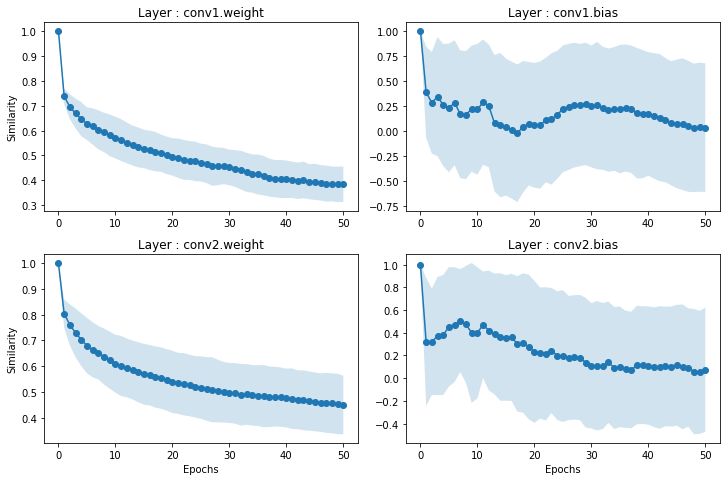

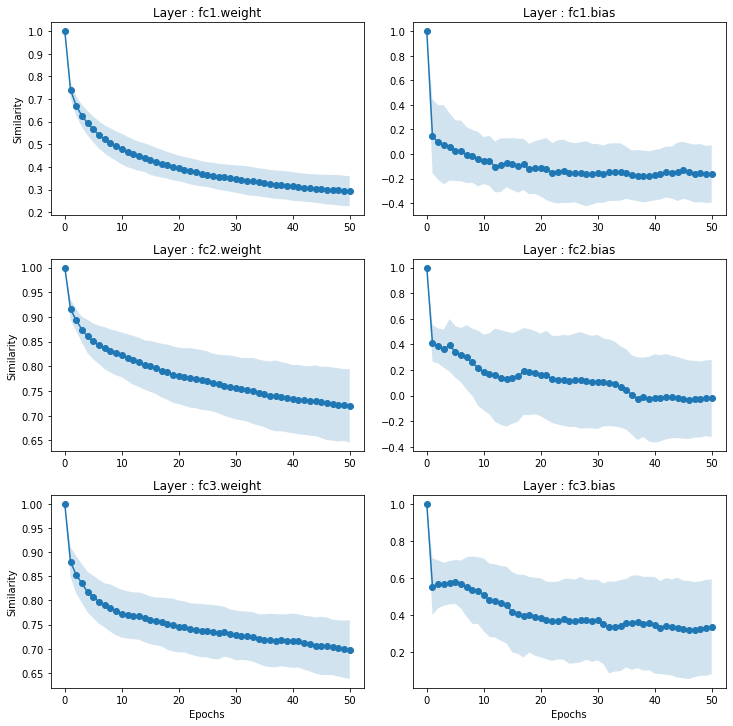

In [27]:
# Use cosine similarity
compare_weights_all_layers('results/weights/weights_sequence_zo_adamm_0.1111111119389534', 'results/weights/weights_sequence_adamm_0.1111111119389534', distance=False)

Below we consider the projection of the convolutional layer weight but done separately for each channel (filter) of each convolutional layer.
This can gives information about whether some filter swap their roles (i.e. their index in the convolution layer weights) between the FO and ZO methods.

In [28]:
def project_weights_per_filter(zo_data, fo_data, ax, title='', num_channels = 3):
    """
    Project down and plot the weights of the convolutional layers
    separately for each filter in the given layer
    :param zo_data: weights sequences of ZO-AdaMM
    :param fo_data: weights sequences of AdaMM
    :param ax: figure axes
    :param title: figure title
    :param num_channels: number of channels in the convolutional kernel
    """
    nb_zo = zo_data.shape[0]
    X = np.zeros((nb_zo*2*num_channels,int(zo_data.shape[1]/num_channels)))

    # Prepare the data
    for i in range(num_channels):
        X[i*nb_zo:(i+1)*nb_zo,:] = zo_data[:,i*X.shape[1]:(i+1)*X.shape[1]]
        X[(nb_zo*num_channels + i * nb_zo):(nb_zo*num_channels + (i + 1) * nb_zo), :] = fo_data[:,
                                                                i * X.shape[1]:(i + 1) * X.shape[1]]

    # Project down onto 2 dimensions
    X_emb = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42).fit_transform(X)

    X_emb_zo = X_emb[:nb_zo*num_channels , :]
    X_emb_fo = X_emb[nb_zo*num_channels:, :]

    # Plot the data
    for i in range(num_channels):
        if i==0:
            ax.plot(X_emb_zo[i*nb_zo:(i+1)*nb_zo, 0], X_emb_zo[i*nb_zo:(i+1)*nb_zo, 1], 'tab:blue', marker='x', label=f'ZO')
            ax.plot(X_emb_fo[i*nb_zo:(i+1)*nb_zo, 0], X_emb_fo[i*nb_zo:(i+1)*nb_zo, 1], 'tab:orange', marker='x', label=f'FO')
        else:
            ax.plot(X_emb_zo[i * nb_zo:(i + 1) * nb_zo, 0], X_emb_zo[i * nb_zo:(i + 1) * nb_zo, 1], 'tab:blue', marker='x')
            ax.plot(X_emb_fo[i * nb_zo:(i + 1) * nb_zo, 0], X_emb_fo[i * nb_zo:(i + 1) * nb_zo, 1], 'tab:orange', marker='x')

        ax.annotate('start', (X_emb_zo[i*nb_zo, 0] + 0.3, X_emb_zo[i*nb_zo, 1]))
        ax.annotate('end', (X_emb_zo[(i + 1)*nb_zo - 1, 0] + 0.3, X_emb_zo[(i + 1)*nb_zo - 1, 1]))
        ax.annotate('start', (X_emb_fo[i*nb_zo, 0] + 0.3, X_emb_fo[i*nb_zo, 1]))
        ax.annotate('end', (X_emb_fo[(i + 1)*nb_zo - 1, 0] + 0.3, X_emb_fo[(i + 1)*nb_zo - 1, 1]))
        ax.legend(loc='upper left')

    fig = plt.gcf()
    ax.set_title(f'Layer : {title}')


def project_weights_all_layers_per_filter(path_zo, path_fo, experiment_num, nb=10, path='plots/weights_projection'):
    """
    Project the weights separately for each filter of the convolutional layers.
    :param path_zo: path to the ZO data
    :param path_fo: path to the FO data
    :param experiment_num: index of the experiment to show
    :param nb: number of experiments done
    :param path: where to save the plot
    """
    # Load the data
    conv_data = load_weights_sequence_all_layers(path_zo, path_fo, nb, conv_layers=True)
    fc_data = load_weights_sequence_all_layers(path_zo, path_fo, nb, conv_layers=False)

    # Don't show the bias
    conv_data.pop('conv1.bias')
    conv_data.pop('conv2.bias')
    fc_data.pop('fc1.bias')
    fc_data.pop('fc2.bias')
    fc_data.pop('fc3.bias')

    # Plot the convolutional layers
    fig, axs = plt.subplots(1, 2)

    for i, (l, d) in enumerate(conv_data.items()):
        project_weights_per_filter(d['zo'][experiment_num], d['fo'][experiment_num], axs[i], title=l)

    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    fig.text(0.5, 0.01, 'x', ha='center')
    fig.text(0.05, 0.5, 'y', va='center', rotation='vertical')

    plt.savefig(f'{path}_conv.png')

    # Plot the fc layers
    fig, axs = plt.subplots(1, 3)

    for i, (l, d) in enumerate(fc_data.items()):
        project_weights([d['zo'][experiment_num]], [d['fo'][experiment_num]], axs[i], title=l, use_pca='auto')

    fig = plt.gcf()
    fig.set_size_inches(10, 5)
    fig.text(0.5, 0.01, 'x', ha='center')
    fig.text(0.05, 0.5, 'y', va='center', rotation='vertical')
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels)
    plt.savefig(f'{path}_fc.png')

    plt.show()

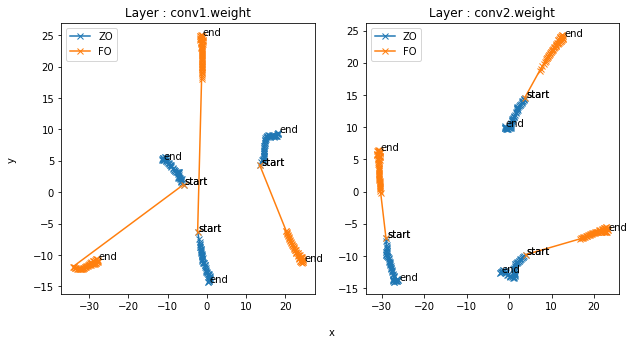

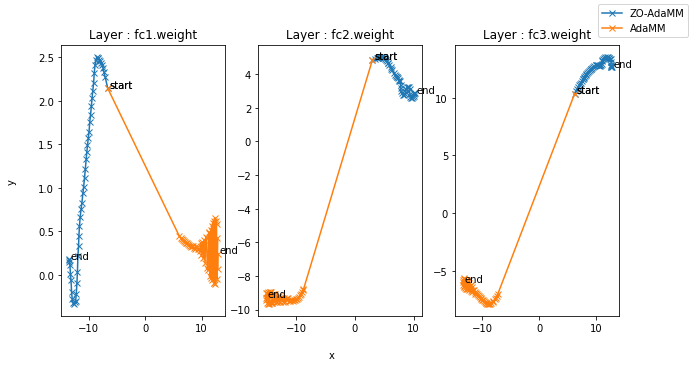

In [29]:
project_weights_all_layers_per_filter('results/weights/weights_sequence_zo_adamm_0.1111111119389534', 'results/weights/weights_sequence_adamm_0.1111111119389534', experiment_num=0)

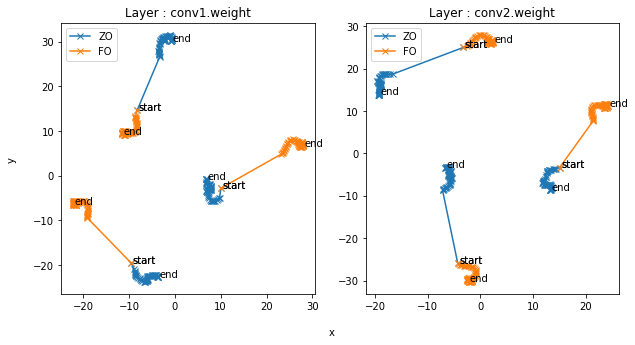

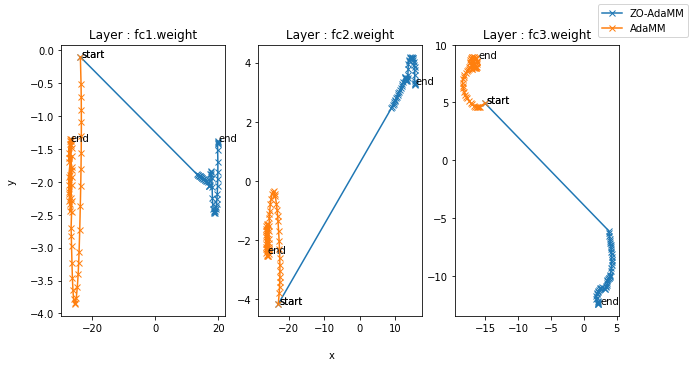

In [30]:
project_weights_all_layers_per_filter('results/weights/weights_sequence_zo_adamm_12.333333015441895', 'results/weights/weights_sequence_adamm_12.333333015441895', 0)

Below, we consider the actual "image representation" of the filter learned by the model.

In [32]:
def print_filters(path_zo, path_fo,num_experiment, nb=10):
    """
    Print the optimized filters of the convolutional layers
    :param path_zo: path to the ZO data
    :param path_fo: path to the FO data
    :param num_experiment: index of the experiment to show
    :param nb: number of experiments done
    """
    conv_data = load_weights_sequence_all_layers(path_zo, path_fo, nb, conv_layers=True)

    conv_data.pop('conv1.bias')
    conv_data.pop('conv2.bias')
    conv_data.pop('conv2.weight')

    for i, (l, d) in enumerate(conv_data.items()):
        fig, axs = plt.subplots(2, 3)
        print_weights(d['zo'][num_experiment], d['fo'][num_experiment], axs)

        fig = plt.gcf()
        fig.suptitle("First convolutional layer's filters", fontsize=16)
        fig.set_size_inches(10, 10)
        plt.show()


def print_weights(zo_data, fo_data, axs, num_channels = 3):
    """
    Print an individual filter
    :param zo_data: data for ZO optimizer
    :param fo_data: data for FO optimizer
    :param axs: figure axes
    :param num_channels: number of channels per convolution kernel
    """
    nb_zo = zo_data.shape[0]
    X = np.zeros((nb_zo*2*num_channels,int(zo_data.shape[1]/num_channels)))

    # Prepare the data
    for i in range(num_channels):
        X[i*nb_zo:(i+1)*nb_zo,:] = zo_data[:,i*X.shape[1]:(i+1)*X.shape[1]]
        X[(nb_zo*num_channels + i * nb_zo):(nb_zo*num_channels + (i + 1) * nb_zo), :] = fo_data[:,
                                                                i * X.shape[1]:(i + 1) * X.shape[1]]

    # Plot the data
    for i in range(num_channels):
        axs[0,i].imshow(X[(i+1)*nb_zo-1,:].reshape((int(math.sqrt(X.shape[1])),int(math.sqrt(X.shape[1])))), cmap='gray')
        axs[0, i].set_title(f"ZO filter {i}")
        axs[1, i].imshow(X[nb_zo*num_channels+(i+1)*nb_zo-1,:].reshape((int(math.sqrt(X.shape[1])),int(math.sqrt(X.shape[1])))), cmap='gray')
        axs[1, i].set_title(f"FO filter {i}")

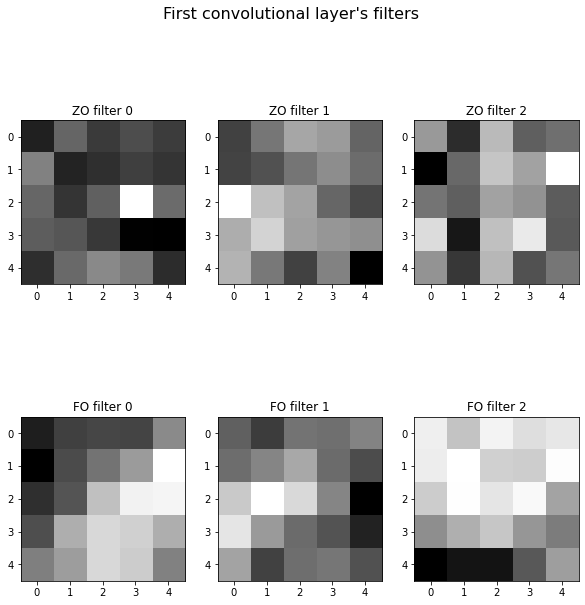

In [33]:
print_filters('results/weights/weights_sequence_zo_adamm_0.1111111119389534', 'results/weights/weights_sequence_adamm_0.1111111119389534', 0)

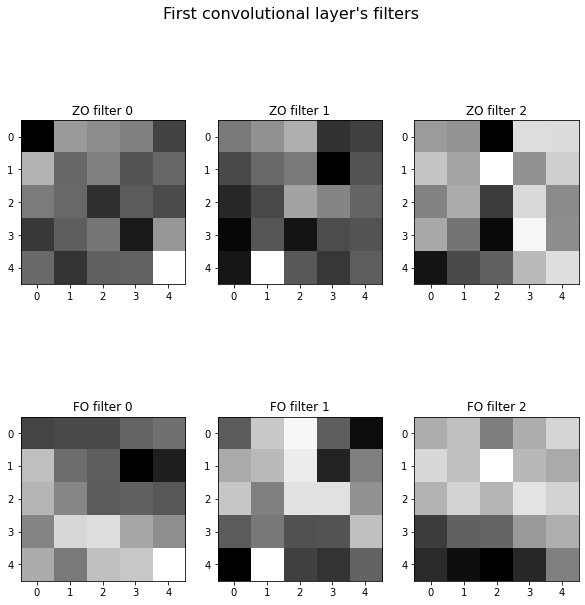

In [34]:
print_filters('results/weights/weights_sequence_zo_adamm_12.333333015441895', 'results/weights/weights_sequence_adamm_12.333333015441895', 0)